Sample script to show each models output

In [5]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pysb.logging import setup_logger
from pysb.simulator import CudaSSASimulator, ScipyOdeSimulator, OpenCLSSASimulator, StochKitSimulator, BngSimulator
from pysb.examples.earm_1_0 import model as earm_model
# from pysb.examples.schlogl import model as schoelgl_model
from pysb.examples.kinase_cascade import model as kinase_model
from pysb.examples.michment import model as michment_model

In [41]:
tspan = np.linspace(0, 10, 101)
sim = OpenCLSimulator(michment_model, tspan=tspan, verbose=True)
traj = sim.run(number_sim=100).dataframe
traj.reset_index(inplace=True)

# ode = ScipyOdeSimulator(michment_model, tspan=tspan).run()

2020-04-12 13:27:19.424 - pysb - INFO - Logging started on PySB version 1.9.0+118.g7a53320.dirty
2020-04-12 13:27:19.425 - pysb - INFO - Log entry time offset from UTC: -7.00 hours
2020-04-12 13:27:20.251 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.michment] Initialized OpenCLSimulator class
2020-04-12 13:27:20.252 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.michment] Simulation(s) started
2020-04-12 13:27:20.257 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.michment] Output OpenCl file to ssa_opencl_code.cl


Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x2084b85aa70>
[1] <pyopencl.Platform 'AMD Accelerated Parallel Processing' at 0x7ffb23d36d30>
Choice [0]:0


2020-04-12 13:27:23.694 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.michment] Creating content on device
2020-04-12 13:27:23.697 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.michment] Completed transfer in: 0.0025s


Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.


LogicError: clEnqueueNDRangeKernel failed: INVALID_WORK_GROUP_SIZE

In [23]:
print(traj.head(10))
obs = ['E_free','S_free', 'ES_complex', 'Product']

   simulation  time  __s0   __s1  __s2  __s3  E_free  S_free  ES_complex  \
0           0   0.0  10.0  100.0   0.0   0.0    10.0   100.0         0.0   
1           0   1.0  10.0   95.0   0.0   5.0    10.0    95.0         0.0   
2           0   2.0  10.0   82.0   0.0  18.0    10.0    82.0         0.0   
3           0   3.0   9.0   71.0   1.0  28.0     9.0    71.0         1.0   
4           0   4.0  10.0   66.0   0.0  34.0    10.0    66.0         0.0   
5           0   5.0  10.0   63.0   0.0  37.0    10.0    63.0         0.0   
6           0   6.0  10.0   57.0   0.0  43.0    10.0    57.0         0.0   
7           0   7.0  10.0   53.0   0.0  47.0    10.0    53.0         0.0   
8           0   8.0  10.0   51.0   0.0  49.0    10.0    51.0         0.0   
9           0   9.0  10.0   47.0   0.0  53.0    10.0    47.0         0.0   

   Product  
0      0.0  
1      5.0  
2     18.0  
3     28.0  
4     34.0  
5     37.0  
6     43.0  
7     47.0  
8     49.0  
9     53.0  


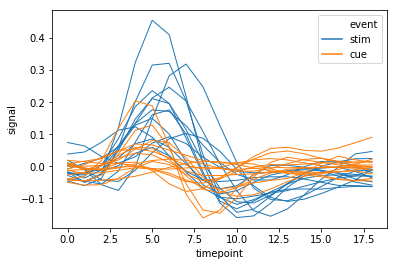

In [38]:
fmri = sns.load_dataset("fmri")
fmri.head(10)
ax = sns.lineplot(x="timepoint", y="signal", hue="event",
                  units="subject", estimator=None, lw=1,
                  data=fmri.query("region == 'frontal'"))

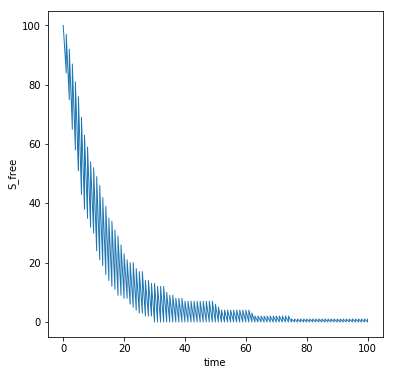

In [40]:
plt.figure(figsize=(6,6))
ax = sns.lineplot(
    x="time", y='S_free', #units="simulation",
#     markers=True, dashes=True,
#     ci='sd',
    lw=1,
    estimator=None, #np.average,
#     hue="simulator", 
    data=traj
)

2020-04-12 13:11:55.964 - pysb - INFO - Logging started on PySB version 1.9.0+118.g7a53320.dirty
2020-04-12 13:11:55.965 - pysb - INFO - Log entry time offset from UTC: -7.00 hours
2020-04-12 13:11:56.792 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.michment] Initialized OpenCLSimulator class
2020-04-12 13:12:00.288 - pysb.simulator.scipyode - INFO - [pysb.examples.michment] Simulation(s) started
2020-04-12 13:12:01.975 - pysb.simulator.scipyode - INFO - [pysb.examples.michment] All simulation(s) complete


In [2]:
sns.lineplot(x="timepoint", y="signal", data=sim)

In [9]:
def run_model(model, tspan, n_sim=1000, obs=None):
    sim = OpenCLSSASimulator(model, tspan=tspan, verbose=True, precision=np.float64)

    ode = ScipyOdeSimulator(model, tspan=tspan).run()

#     sim = CUDASimulator(model, tspan=tspan, verbose=True, )
    traj = sim.run(tspan=tspan, number_sim=n_sim)
    plot(traj, ode, tspan, obs, obs)
    return
    for n, i in enumerate(model.species):
        name = '__s{}'.format(n)
        print(name)
        plot(traj, ode, tspan, name, i)

def plot(traj, ode, tspan, obs, title):
    x = traj.dataframe[obs].unstack(0).values

    plt.figure()
    plt.title(title)
    # create line traces
    plt.plot(tspan, x, '0.5', lw=2, alpha=0.25)  # individual trajectories
    plt.plot(tspan, x.mean(1), 'k-*', lw=3, label="Mean")
    plt.plot(tspan, x.min(1), 'b--', lw=3, label="Minimum")
    plt.plot(tspan, x.max(1), 'r--', lw=3, label="Maximum")

    # adding ODE solution to plot
    plt.plot(tspan, ode.dataframe[name], 'g--', lw=3, label="ODE")

    plt.xlabel('Time(s)')
    plt.ylabel('Number of molecules')
    if not os.path.exists("figures"):
        os.mkdir('figures')
    plt.savefig('figures/{}.png'.format(name), bbox_inches='tight')
    

2019-07-24 11:41:56.370 - pysb - INFO - Logging started on PySB version 1.7.0+164.gdf96d86.dirty
2019-07-24 11:41:56.371 - pysb - INFO - Log entry time offset from UTC: -7.00 hours
2019-07-24 11:41:56.408 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Initialized OpenCLSimulator class
2019-07-24 11:41:56.413 - pysb.simulator.scipyode - WARNING - [pysb.examples.earm_1_0] This system of ODEs will be evaluated in pure Python. This may be slow for large models. We recommend installing a package for compiling the ODEs to C code: 'weave' (recommended for Python 2) or 'cython' (recommended for Python 3). This warning can be suppressed by specifying compiler='python'.
2019-07-24 11:41:56.476 - pysb.simulator.scipyode - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2019-07-24 11:41:56.571 - pysb.simulator.scipyode - INFO - [pysb.examples.earm_1_0] All simulation(s) complete
2019-07-24 11:41:56.599 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s)

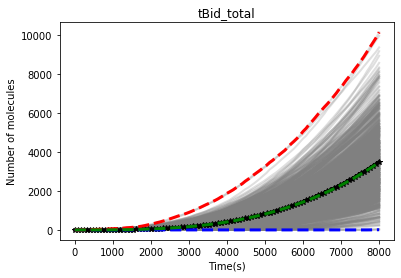

In [7]:

tspan = np.linspace(0, 8000, 101)
name = 'tBid_total'
# name = 'tBid_total'
run_model(earm_model, tspan, n_sim=1000, obs=name)

2021-01-08 11:52:42.788 - pysb - INFO - Logging started on PySB version 1.11.0+161.gbe59ff0.dirty
2021-01-08 11:52:42.788 - pysb - INFO - Log entry time offset from UTC: -8.00 hours
2021-01-08 11:52:42.796 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] Initialized OpenCLSSASimulator class
2021-01-08 11:52:42.812 - pysb.simulator.scipyode - INFO - [pysb.examples.kinase_cascade] Simulation(s) started
2021-01-08 11:52:42.863 - pysb.simulator.scipyode - INFO - [pysb.examples.kinase_cascade] All simulation(s) complete
2021-01-08 11:52:42.881 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] Simulation(s) started
2021-01-08 11:52:42.891 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] Output OpenCl file to ssa_opencl_code.cl


Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x1f1fe9fc380>
[1] <pyopencl.Platform 'AMD Accelerated Parallel Processing' at 0x7ffd69516d30>
Choice [0]:1


2021-01-08 11:52:46.177 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] Using device AMD Ryzen 9 3900X 12-Core Processor            


Set the environment variable PYOPENCL_CTX='1' to avoid being asked again.


2021-01-08 11:52:46.609 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] Creating content on device
2021-01-08 11:52:56.265 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] 100 simulations in 9.6555s
2021-01-08 11:52:56.266 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.kinase_cascade] Retrieved trajectories in 9.6565s


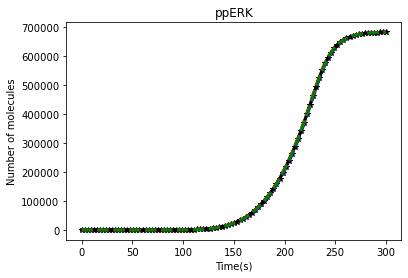

In [10]:
tspan = np.linspace(0, 300, 101)
name = 'ppERK'
run_model(kinase_model, tspan, 100, obs=name)
    

In [ ]:
tspan = np.linspace(0, 100, 101)
name = 'X_total'

run_model(scholgl_model, tspan, n_sim=2**12, obs=name)

In [43]:

def save_output(model, tspan, n_sim=1000):
    name = model.name.split('.')[-1]
    
    def save_traj(traj, sim):
        s_name = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim=sim)
        traj.to_csv(s_name, compression='gzip')
        
    print("Running OpenCLSimulator")
    traj = OpenCLSimulator(model, platform='NVIDIA',device='gpu'
                          ).run(tspan=tspan, number_sim=n_sim).dataframe
    save_traj(traj, 'opencl')
    
    print("Running CUDASimulator")
    traj = CUDASimulator(model).run(tspan=tspan, number_sim=n_sim).dataframe
    save_traj(traj, 'cuda')
    
    print("Running BngSimulator")
    traj = BngSimulator(model).run(tspan=tspan, n_runs=n_sim).dataframe
    save_traj(traj, 'bng')
    
    print("Running StochKitSimulator")
    traj = StochKitSimulator(model).run(tspan=tspan, n_runs=n_sim).dataframe
    save_traj(traj, 'stochkit')
    
def load_traj(model, n_sim=1000):
    
    name = model.name.split('.')[-1]
    bng_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='bng')
    stochkit_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='stochkit')
    cuda_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='cuda')
    opencl_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='opencl')
    
    bng_data = pd.read_csv(bng_file)
    stochkit_data = pd.read_csv(stochkit_file)
    cuda_data = pd.read_csv(cuda_file)
    opencl_data = pd.read_csv(opencl_file)
    bng_data['simulator'] = 'bng'
    stochkit_data['simulator'] = 'stochkit'
    cuda_data['simulator'] = 'CUDASimulator'
    opencl_data['simulator'] = 'OpenCLSimulator'

    df = pd.concat([bng_data, stochkit_data, cuda_data, opencl_data], ignore_index=True)
    return df

In [34]:
def create_plot(df, obs):
    plt.figure(figsize=(6,6))
    ax = sns.lineplot(
        x="time", y=obs,
        markers=True, dashes=True,
        ci='sd', 
        estimator=np.average,
        hue="simulator", 
        data=df
    )

In [ ]:
tspan = np.linspace(0, 100, 301)
scholgl_model.parameters['X_0'].value = 250
save_output(scholgl_model, tspan, n_sim=1000)

Running OpenCLSimulator


In [26]:
tspan = np.linspace(0, 5000, 101)
save_output(earm_model, tspan, n_sim=1000)

In [39]:
df = load_traj(scholgl_model, n_sim=1000)

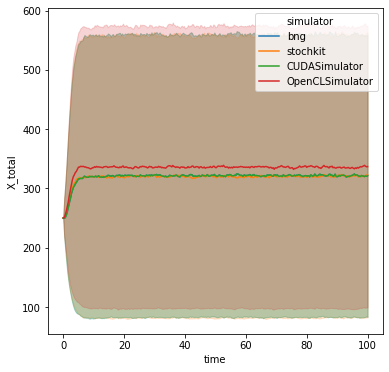

In [40]:
create_plot(df, 'X_total')